In [1]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
from tqdm import tqdm
import torch

from sacred import SETTINGS, Experiment
from functools import partial

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.base.vae import VAE, AE
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.cfm.components.simple_mlp import VelocityNet
 
from conditional_flow_matching import *

from torch.optim import AdamW

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

from conditional_flow_matching import *

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
adata=sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/eb_phate_latents.h5ad")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Import configurations

In [3]:
with open("/nfs/homedirs/pala/scCFM/configs/ae/eb/config.yaml", "r") as stream:
    hparams_ae = yaml.safe_load(stream)["fixed"]

In [4]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

## Initialize and train/load autoencoder 

In [5]:
pretrained_ae = True
pretrained_ckpt_ae = "/nfs/students/pala/scCFM/experiments/ae/eb_vae/checkpoints/epoch_0033.ckpt"

In [6]:
task_name = hparams_ae["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams_ae["training.training"]["seed"])      
if hparams_ae["training.training"]["seed"]: 
    pl.seed_everything(hparams_ae["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / "ae" / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = scDataModule(**hparams_ae["datamodule.datamodule"])


# Initialize the model 
ae_model = VAE(in_dim = datamodule.dim,
            **hparams_ae["model.model"]
            ) 
        
if not pretrained_ae:
    # Initialize callbacks 
    model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                            **hparams_ae["model_checkpoint.model_checkpoint"])


    # Initialize callbacks 
    early_stopping_callbacks = EarlyStopping(**hparams_ae["early_stopping.early_stopping"])


    # Initialize logger 
    logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                         **hparams_ae["logger.logger"]) 


    # Initialize the lightning trainer 
    trainer = Trainer(default_root_dir=current_experiment_dir,
                      callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                      logger=logger, 
                      **hparams_ae["trainer.trainer"])


    # # Fit the model 
    trainer.fit(model=ae_model, 
                      train_dataloaders=datamodule.train_dataloader(),
                      val_dataloaders=datamodule.val_dataloader())
    train_metrics = trainer.callback_metrics

else:
    ae_model.load_state_dict(torch.load(pretrained_ckpt_ae)["state_dict"])

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


**Analyze autoencoder latent space**

In [8]:
z_cells = []
annot = []
ae_model.eval()
with torch.no_grad():
    for cell, cond in zip(adata.X.A, adata.obs.experimental_time):
        annot.append(cond)
        X = torch.from_numpy(cell).unsqueeze(0).float()
        mu = ae_model.encode(torch.log(1 + X))["z"]
        z_cells.append(mu)

z_cells= torch.cat(z_cells, dim=0)
annot = pd.DataFrame(annot)
annot.columns = ["experimental_time"]

adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.tl.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

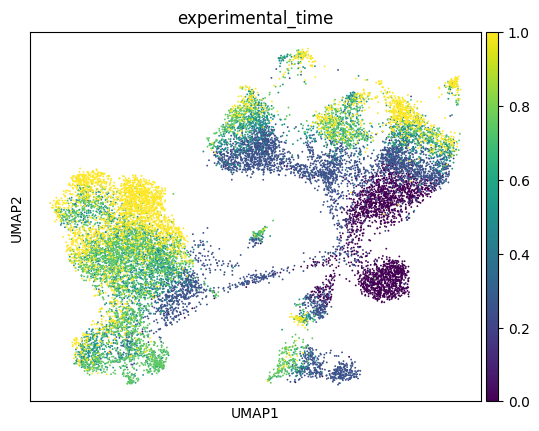

In [10]:
sc.pl.umap(adata_latent, color="experimental_time")

## Perform CFM training like in the notebook

In [11]:
with open("/nfs/homedirs/pala/scCFM/configs/trajectory/eb/config.yaml", "r") as stream:
    hparams_cfm = yaml.safe_load(stream)["fixed"]

In [12]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
task_name = hparams_cfm["training.training"]["task_name"]
    
# Initialize datamodule
datamodule = TrajectoryDataModule(**hparams_cfm["datamodule.datamodule"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
adata.obsm["X_latents"]

array([[-5.5685844e-02, -1.1206503e-01,  2.7994496e-01, ...,
         3.3206493e-01, -5.7187593e-01, -3.1886503e-01],
       [ 8.3094880e-02,  4.3845317e-01,  3.4195909e-01, ...,
         4.1381651e-01, -7.6176435e-01,  4.5770779e-05],
       [ 2.3776583e-01,  1.0422921e+00,  2.3209840e-01, ...,
         1.7515847e-01, -5.1164973e-01,  2.9754388e-01],
       ...,
       [-1.9963637e-01,  4.6097246e-01, -6.2867917e-02, ...,
        -8.1401192e-02,  5.4528099e-01, -1.4538471e+00],
       [ 2.1141995e-01, -1.1547964e-02,  1.0079358e-01, ...,
         1.5267714e+00,  9.0856016e-01, -2.3074344e-01],
       [ 5.5294007e-01,  3.9703578e-02,  2.0173278e-01, ...,
         3.1739479e-01,  2.2662295e-02,  4.6853125e-01]], dtype=float32)

In [15]:
train_dataloader = datamodule.train_dataloader()

First we standardize the coordinates

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 64
model = MLP(dim=dim, time_varying=True, w=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
ae_model = ae_model.cuda()

Batch collecting function

In [17]:
def get_batch(FM, batch, n_times, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    batch = torch.stack(batch, dim=1).to("cuda")
    for t_start in range(n_times - 1):
        with torch.no_grad():
            x0 = batch[:, t_start, :]
            x1 = batch[:, t_start+1, :]
        
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

Train OT cfm

In [18]:
for iteration in tqdm(range(10000)):
    batch = next(iter(train_dataloader))
    optimizer.zero_grad()
    t, xt, ut = get_batch(FM=FM, batch=batch, n_times=5)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if iteration % 20 == 0:
        print(loss.item())

  0%|          | 1/10000 [00:01<3:22:45,  1.22s/it]

0.4402010142803192


  0%|          | 21/10000 [00:23<3:04:40,  1.11s/it]

0.42356473207473755


  0%|          | 41/10000 [00:46<3:07:49,  1.13s/it]

0.4154199957847595


  0%|          | 45/10000 [00:51<3:09:53,  1.14s/it]


KeyboardInterrupt: 

**Check the streamplots**

In [ ]:
def add_velocity_to_adata(adata, model):
    # Put model in evaluation mode
    model.eval()
    velocities = []
    with torch.no_grad():
        for i, x in enumerate(adata.X):
            t = torch.tensor(adata.obs.experimental_time[i]).view(1, -1).float().cuda()
            x = torch.from_numpy(x).view(1, -1).float().cuda()
            dx_dt = model(torch.cat([x, t], dim=1))
            velocities.append(dx_dt.cpu().numpy())
    velocities = np.concatenate(velocities, axis=0)

    adata.layers["velocity"] = velocities

In [ ]:
add_velocity_to_adata(adata_latent, model)

In [ ]:
adata_latent.layers["X_latent"] = adata_latent.X.copy()

In [ ]:
vk = cr.kernels.VelocityKernel(adata_latent,
                          xkey="X_latent", 
                        vkey="velocity").compute_transition_matrix()

vk.compute_projection(basis="umap")

In [ ]:
scv.pl.velocity_embedding_stream(adata_latent, vkey="T_fwd", basis="umap", color="experimental_time")

**Propagate with neural ODE**

In [ ]:
times = sorted(adata_latent.obs["experimental_time"].unique())
X = [
    adata_latent.X[adata_latent.obs["experimental_time"] == t]
    for t in times
]

In [ ]:
node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

# Append first time point
trajs = []
with torch.no_grad():
    X_pf = torch.from_numpy(X[0])
    trajs.append(X_pf.unsqueeze(0))
    for t in range(4):
        traj = node.trajectory(X_pf.float().to(device),
            t_span=torch.linspace(t, t+1, 400),
        ).cpu()
        X_pf = traj[-1]
        trajs.append(X_pf.unsqueeze(0))

trajs = torch.cat(trajs, dim=0)

In [ ]:
X_pf.shape

In [ ]:
X_pf = trajs.view(trajs.shape[0]*trajs.shape[1], -1)
times = torch.arange(5).unsqueeze(1).expand(trajs.shape[0],trajs.shape[1]).ravel()
times = pd.DataFrame(times)
times.columns = ["experimental_time"]

In [ ]:
times.shape

In [ ]:
adata_pf = sc.AnnData(X=X_pf.cpu().numpy(), 
                     obs=times)

In [ ]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

In [ ]:
sc.pl.umap(adata_pf, color="experimental_time")

Co-embed

In [ ]:
X_total = np.concatenate([adata_latent.X, X_pf], axis=0)
dataset_type = ["True" for _ in range(adata_latent.X.shape[0])] + \
                ["False" for _ in range(X_pf.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["Dataset_type"]

In [ ]:
adata_pf = sc.AnnData(X=X_total, 
                     obs=dataset_type)

In [ ]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

In [ ]:
sc.pl.umap(adata_pf, color="Dataset_type")